# Notebook to run orbits of clusters and streams

You can read more about astropy units here:
https://docs.astropy.org/en/stable/units/index.html

You can read more about the gala pacakge which is used throughout this notebook for orbit integration, potentials etc here:
http://gala.adrian.pw/en/latest/

In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
import astropy.constants as const


import galstreams

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 22 #label_size 
mpl.rcParams['ytick.labelsize'] = 22 #label_size 

## Set up the potential models:

Load the new Gala Milky Way model:

In [3]:
# you'll need to change this path to the folder where you store the file I sent 
# I will send you this file
# this potential includes a dark matter halo, disk, and bulge + nucleus for the MW
mw = gp.load('MilkyWayPotential2022.yml')

In [80]:
xyz = np.zeros((3, 1024))
xyz[0] = np.linspace(0, 25, xyz.shape[1])

In [10]:
def stream_mass_from_width(r,width):
    """
    computes stream mass estimate given its width
    params: r, stream galactocentric distance (kpc)
            width, stream width (pc)
    returns: stream width estimate in solar masses
    """
    w = width/(r*1000)
    xyz = np.zeros((3, 1024))
    xyz[0] = [r]
    mprof = mw.mass_enclosed(xyz)
    M_r = mprof[0]
    mass_estimate = 2**(1/2)*3**(3/2)*M_r*w**3
    return mass_estimate

In [13]:
stream_mass_from_width(r=18.9,width=53)

<Quantity 32244.9860542 solMass>

(0.0, 250.0)

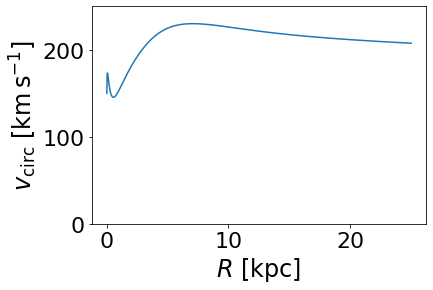

In [45]:
# plot the circular velocity of the potential with galactocentric radius
for pot in [mw]:
    vcirc = pot.circular_velocity(xyz)
    plt.plot(xyz[0], vcirc)
plt.xlabel('$R$ [kpc]')
plt.ylabel(r'$v_{\rm circ}$ ' + f'[{vcirc.unit:latex_inline}]')
plt.ylim(0, 250)

Plot the density at the midplane of the  potential model:

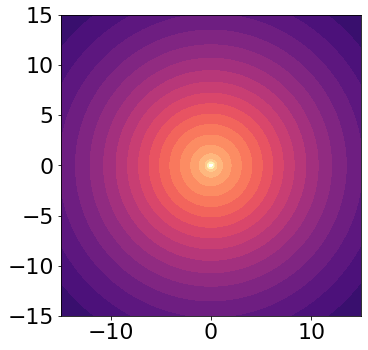

In [6]:
grid = (np.linspace(-15, 15, 128), np.linspace(-15, 15, 128), 0)
levels = np.geomspace(1e6, 1e10, 24)

fig, axes = plt.subplots(
    1, 1, 
    figsize=(5, 5), 
    sharex=True, sharey=True,
    constrained_layout=True
)
for pot in [mw]:
    pot.plot_density_contours(
    grid=grid, ax=axes, 
    levels=levels, cmap='magma', 
    norm=mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max()))
    axes.set_aspect('equal')

## Set up hamiltonian 

In [10]:

test_frame = gp.StaticFrame(galactic)

H = gp.Hamiltonian(mw, test_frame)


In [47]:
for i,name in enumerate(df["# Name"]):
    if name == "NGC_3201":
        print(i)

18


## Transform from 6d phase space sky coords to galactic coords

To integrate the orbits of streams and clusters you need their 6D phase space coordinates (ra,dec,distance,proper motion1,proper motion2, radial velocity) in galactic coordinates in your potential (x,y,z,vx,vy,vz)

See more info here  https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html

In [22]:
df = pd.read_fwf("input.txt")

In [23]:
def integrate_orbit(name,verbose=False,return_vals=False):

    index = df.loc[df['# Name'] == name].index[0]

    ra = df['ra'][index]*u.degree
    dec = df['dec'][index]*u.degree
    pm_ra = df['pmra'][index]*u.mas/u.yr
    pm_dec = df['pmdec'][index]*u.mas/u.yr
    vlos = df['vlos'][index]*u.km/u.s
    dist = df['dist'][index]*u.kpc


    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pm_ra,
                        pm_dec=pm_dec,
                        radial_velocity=vlos,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )

    #print('orbit pericenter and apocenter')
    #here you can easily compute the orbital parameters such as apocenter/pericenter 
    #print(prog_orbit.pericenter(), prog_orbit.apocenter())
    if verbose:
        fig = prog_orbit.plot();
        fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)
        
    if return_vals:
        return prog_orbit.pericenter().value, prog_orbit.apocenter().value, np.median(prog_orbit.energy()).value, np.median(prog_orbit.angular_momentum()[-1]).value

(9.89571398166642, 17.715680689896303)

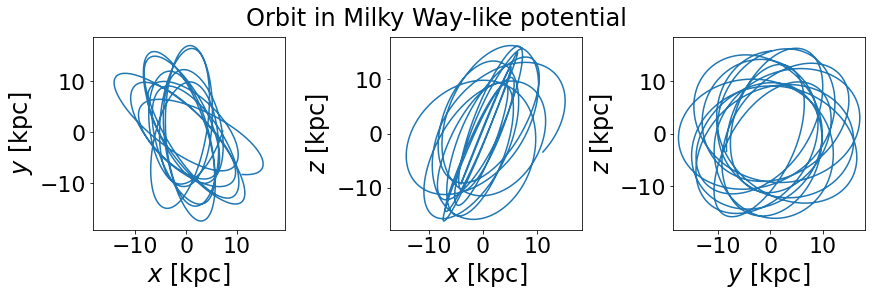

In [79]:
integrate_orbit(name='Pal_5',return_vals=True,verbose=True)

In [24]:
%%time
apocenters = np.zeros(len(df["# Name"]))
pericenters = np.zeros(len(df['# Name']))
energies = np.zeros(len(df["# Name"]))
lz = np.zeros(len(df["# Name"]))


for i,name in enumerate(df["# Name"]):
    try:
        pericenters[i] = integrate_orbit(name=name,return_vals=True)[0]
        apocenters[i] = integrate_orbit(name=name,return_vals=True)[1]
        energies[i] = integrate_orbit(name=name,return_vals=True)[2]
        lz[i] = integrate_orbit(name=name,return_vals=True)[3]
        
    except RuntimeError:
        pericenters[i] = float('nan')
        apocenters[i] = float('nan')

df['apocenter'] = apocenters
df['pericenter'] = pericenters

CPU times: user 1min 5s, sys: 1.01 s, total: 1min 6s
Wall time: 1min 6s


In [25]:
delta = np.array(df["rmax"])
dists = np.array(df["dist"])
sigma = np.array(df["sigma"])

radii = dists*delta*60/206_265 ## units are kpc

radii = radii*u.kpc
sigma = sigma*u.km/u.s
alpha = 1

mass_estimate = alpha*radii.to(u.m)*sigma.to(u.m/u.s)**2/const.G
mass_estimate = mass_estimate.to(u.M_sun)

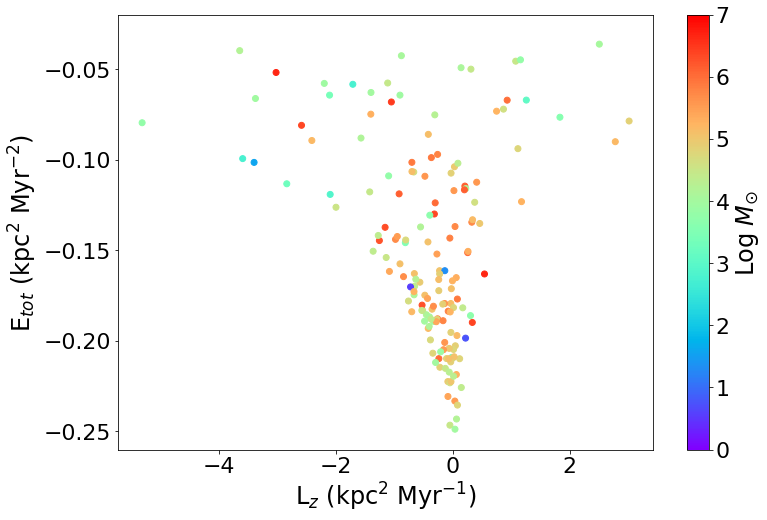

In [26]:
mass_logs = np.round(np.log10(mass_estimate.value),2)

cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)


plt.figure(figsize=(12,8))
plt.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
plt.ylim(-0.26,-0.02)
plt.colorbar(label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")
plt.show()

In [7]:
# example of cluster 6D sky coordinates
# below I use the Pal 5 GC coordinates from Vasiliev et al. 2021

c1 = coord.SkyCoord(ra=229.019*u.degree, dec=-0.121*u.degree,
                    distance=20.6*u.kpc,
                    pm_ra_cosdec=-2.730 *u.mas/u.yr,
                    pm_dec=-2.654 *u.mas/u.yr,
                    radial_velocity=-56.2 *u.km/u.s,
                    frame='icrs')

## Get Lz and Etot for streams with 6D Phase Space info:

In [27]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)

Initializing galstreams library from master_log... 


        Use @ instead. [gala.coordinates.greatcircle]


In [11]:
for st in mws.all_track_names():
    if mws.summary.loc[st]["InfoFlags"] == "1111":
        print (st)

AAU-AliqaUma-L21
AAU-ATLAS-L21
Aquarius-W11
LMS1-Y20
Orphan-K19


In [28]:
tracks = ["AAU-AliqaUma-L21","Pal5-PW19","GD-1-I21","AAU-ATLAS-L21","Aquarius-W11","LMS1-Y20","Orphan-K19",]
stream_mass = np.array([18e4,2e4,1e5,12e4,1e-5,1e-5,1e-5,])
stream_energy = []
stream_momenta = []

for st in tracks:
    ra = np.median(mws[st].track.to_table()["ra"].value)*u.degree
    dec = np.median(mws[st].track.to_table()["dec"].value)*u.degree
    pmra = np.median(mws[st].track.to_table()["pm_ra_cosdec"].value)*u.mas/u.yr
    pmdec = np.median(mws[st].track.to_table()["pm_dec"].value)*u.mas/u.yr
    dist = np.median(mws[st].track.to_table()["distance"].value)*u.kpc
    if st == "Pal5-PW19":
        vrad = -56.2*u.km/u.s
    elif st == "GD-1-I21":
        vrad = -50*u.km/u.s
    
    else:
        vrad = np.median(mws[st].track.to_table()["radial_velocity"].value)*u.km/u.s
    
    
    
    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pmra,
                        pm_dec=pmdec,
                        radial_velocity=vrad,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )
    
    
    stream_energy.append(np.median(prog_orbit.energy()).value)
    stream_momenta.append(np.median(prog_orbit.angular_momentum()[-1]).value)

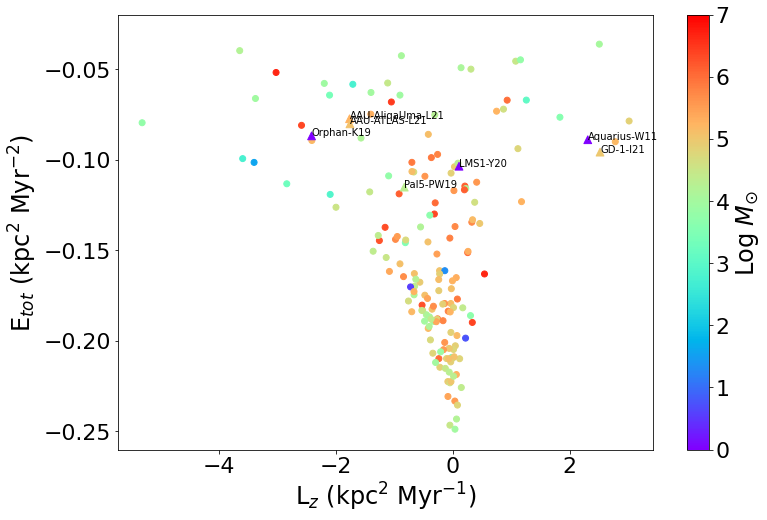

In [29]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta,stream_energy,c=stream_mlogs,cmap=cmap,norm=norm,marker='^',s=60,label=tracks)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks):
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)
    
#ax2.axvline(2.78)
#ax2.axhline(-0.09)
plt.show()

In [30]:
##Aditional Stream info from Ting et. al 2022:

ting_st = ["300S","Ophiucus","Wilka Yaku","Jet","Phoenix","Orphan",
           "Chenab","Jhelum","Indus","Palca","Elqui","Turranburra"]

ting_w = np.array([110,8,127,90,53,747,493,267,240,1000,472,288])
ting_e = np.array([-0.10,-0.16,-0.10,-0.10,-0.13,-0.10,-0.09,-0.12,-0.13,-0.10,-0.09,-0.11])
ting_l = np.array([0.44,-0.15,-2.93,1.65,-1.66,-4,-3.41,-0.4,-1.10,-1.74,-0.09,-2.25])
ting_rgal = np.array([22.2,4.3,36.1,33.9,18.9,17.6,28.0,10.8,12.4,38.5,51.0,31.7])
ting_mass = np.zeros(len(ting_st))

for i in range(len(ting_st)):
    ting_mass[i] = stream_mass_from_width(r=ting_rgal[i],width=ting_w[i]).value
    
ting_logmass = np.log10(ting_mass)

In [32]:
ting_logmass

array([5.30761008, 3.35715596, 5.03344452, 4.64492182, 4.50846219,
       8.02317294, 7.04254095, 7.14849813, 6.8778712 , 7.66020879,
       6.40856926, 6.22434432])

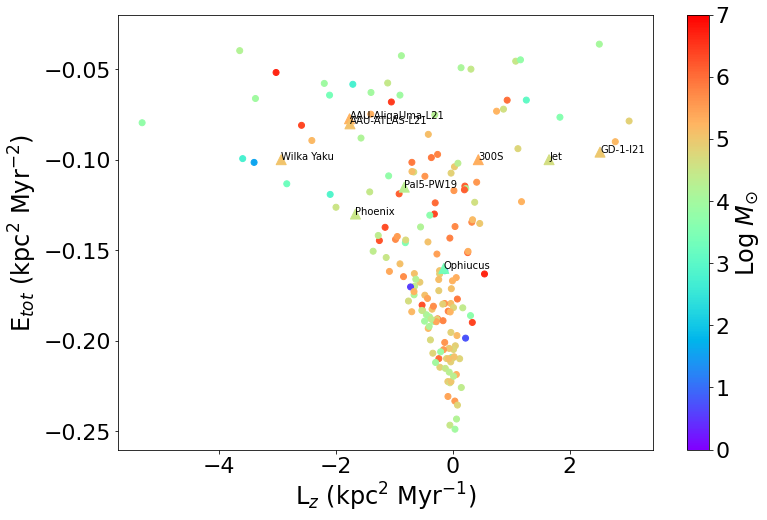

In [35]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = plt.subplot()
ax3 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta[0:4],stream_energy[0:4],c=stream_mlogs[0:4],cmap=cmap,norm=norm,marker='^',s=100,label=tracks)
ax3.scatter(ting_l[0:5],ting_e[0:5],c=ting_logmass[0:5],cmap=cmap,norm=norm,marker='^',s=100,label=ting_st)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks[0:4]):
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)
    
for i, label in enumerate(ting_st[0:5]):
    ax2.annotate(label,(ting_l[i],ting_e[i]),fontsize=10)
#ax2.axvline(palgc_lz)
#ax2.axhline(palgc_e)
plt.show()

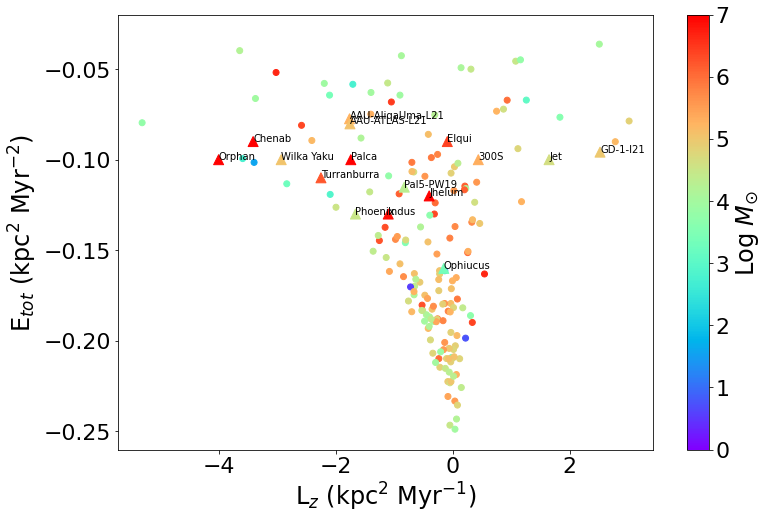

In [37]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = plt.subplot()
ax3 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta[0:4],stream_energy[0:4],c=stream_mlogs[0:4],cmap=cmap,norm=norm,marker='^',s=100,label=tracks)
ax3.scatter(ting_l,ting_e,c=ting_logmass,cmap=cmap,norm=norm,marker='^',s=100,label=ting_st)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks[0:4]):
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)
    
for i, label in enumerate(ting_st):
    ax2.annotate(label,(ting_l[i],ting_e[i]),fontsize=10)
#ax2.axvline(palgc_lz)
#ax2.axhline(palgc_e)
plt.show()

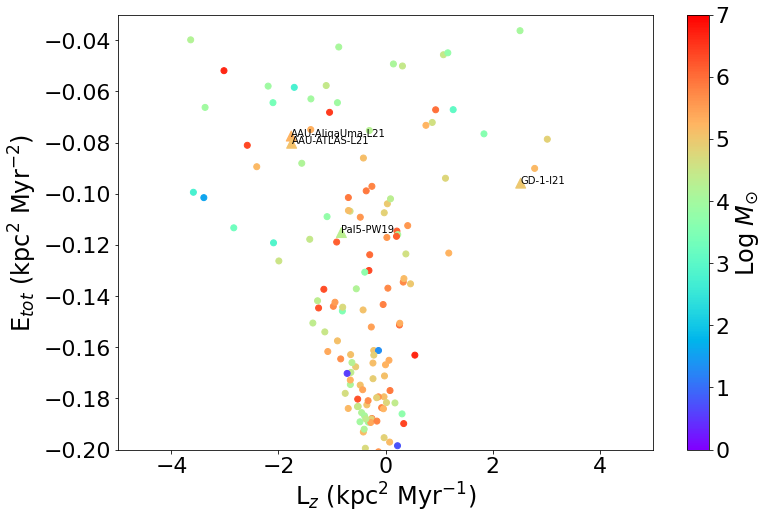

In [19]:
stream_mlogs = np.log10(stream_mass)
cmap = plt.cm.rainbow
norm = mpl.colors.Normalize(vmin=0,vmax=7)

fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = plt.subplot()

img = ax1.scatter(lz,energies,c=mass_logs,norm=norm,cmap=cmap)
ax2.scatter(stream_momenta[0:4],stream_energy[0:4],c=stream_mlogs[0:4],cmap=cmap,norm=norm,marker='^',s=100,label=tracks)
plt.ylim(-0.26,-0.02)
fig.colorbar(img,ax=ax1,label="Log $M_{\odot}$")
plt.xlabel("L$_z$ (kpc$^2$ Myr$^{-1}$)")
plt.ylabel("E$_{tot}$ (kpc$^2$ Myr$^{-2}$)")

for i, label in enumerate(tracks[0:4]):
  
    ax2.annotate(label,(stream_momenta[i],stream_energy[i]),fontsize=10)

plt.ylim(-0.2,-0.03)
plt.xlim(-5,5)
plt.show()

In [77]:
count = 0
for i in pericenters:
    if (np.isnan(i)):
        count += 1
print(count)
       

9


In [85]:
len(df.loc[df["pericenter"] < 10]["pericenter"])

140

In [8]:
#now transform to galactocentric coords (assuming default solar vel + pos - see link above)
gc1 = c1.transform_to(coord.Galactocentric)

In [17]:
print(gc1.x, gc1.y, gc1.z)
print(gc1.v_x, gc1.v_y, gc1.v_z)


7.1970585973536085 kpc 0.22364519881190617 kpc 15.725603167408744 kpc
-45.683760871576744 km / s -149.92448254498515 km / s -11.322419809788432 km / s


## Compute the orbit of the cluster :

We select Pal 5's progenitor orbit from above

In [11]:
glob_w0 = gd.PhaseSpacePosition(
    [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
    [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
)
prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
).to_frame(test_frame)

print(prog_orbit.pericenter(), prog_orbit.apocenter())

7.18575800278673 kpc 16.238725217741308 kpc


Compare orbit plot to orbit in static (non-barred) potential:

orbit pericenter and apocenter
7.18575800278673 kpc 16.238725217741308 kpc


Text(0.5, 0.98, 'Orbit in Milky Way-like potential')

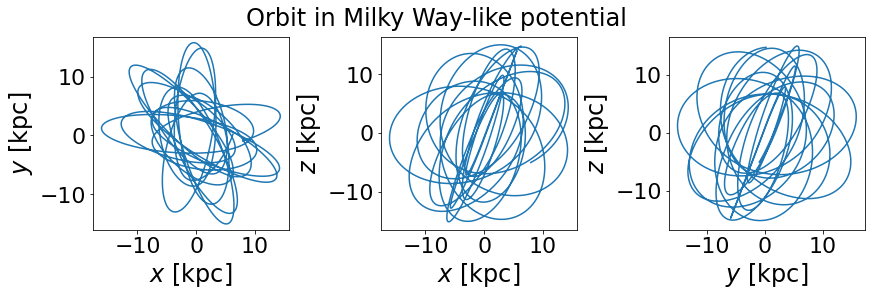

In [12]:
prog_orbit = H.integrate_orbit(
    glob_w0, 
    t=prog_orbit.t,
    Integrator=gi.DOPRI853Integrator
)
print('orbit pericenter and apocenter')
#here you can easily compute the orbital parameters such as apocenter/pericenter 
print(prog_orbit.pericenter(), prog_orbit.apocenter())
fig = prog_orbit.plot()
fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)

In [19]:
np.median(prog_orbit.angular_momentum()[-1])

<Quantity -0.79631084 kpc2 / Myr>

## Compute a stream model 

Now setting up a cluster to run a stream model. You won't need this at first when you just check the pericenters and apocenters of streams vs globulars

In [20]:
glob_pot = gp.HernquistPotential( # we can use a Plummer here if we want
    m=5e4*u.Msun, #mass of your cluster)
    c=1*u.pc, #concentration of your hernquist cluster 
    units=galactic
)
df = gd.FardalStreamDF()
gen = gd.mockstream.MockStreamGenerator(
    gd.FardalStreamDF(random_state=np.random.default_rng(42)), 
    H, 
    glob_pot
)


In [21]:
opts = dict(
    release_every=1, # sets the amount of stars you release every time step 
    dt=-1 * u.Myr, #integration time step, here 1 Myr
    t1=0 * u.Gyr, # intitial time
    t2=-4 * u.Gyr, #amount of time you integrate for ( 4 Gyr)
    n_particles=1 #how many particles you release per time step. 
)

stream, prog = gen.run(
    glob_w0, 
    prog_mass=glob_pot.parameters['m'], 
    **opts
)


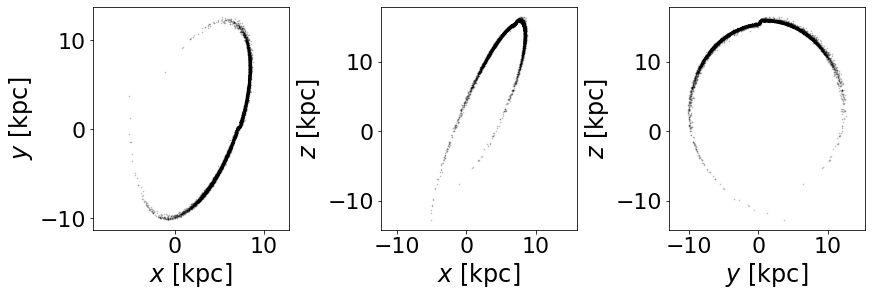

In [22]:
# Plot the stream
stream_style = dict(s=2, alpha=0.2, c='black')
_ = stream.plot(**stream_style)

Great this looks like Pal 5!